In [1]:
import numpy as np
import pandas as pd

def compute_responses_from_sheets(
    data: dict,
    stim_start_time: float,
    baseline_window: float,
    stim_window: float,
    time_col: str | None = None,
    roi_cols: list[str] | None = None,
):
    """
    各シート（trial）から ROIごとの trial応答量
      R = mean(stim window) - mean(baseline window)
    を計算して responses に格納して返す。
    """
    example_df = next(iter(data.values()))
    if time_col is None:
        time_col = example_df.columns[0]
    if roi_cols is None:
        roi_cols = list(example_df.columns[1:])

    responses = {"Kstim": [], "Nstim": [], "Estim": []}

    for sheet_name, df in data.items():
        df = df.dropna(subset=[time_col]).copy()

        baseline = df[(df[time_col] >= stim_start_time - baseline_window) &
                      (df[time_col] <  stim_start_time)]
        stim = df[(df[time_col] >= stim_start_time) &
                  (df[time_col] <  stim_start_time + stim_window)]

        R = stim[roi_cols].mean(axis=0) - baseline[roi_cols].mean(axis=0)

        if "Kstim" in sheet_name:
            responses["Kstim"].append(R)
        elif "Nstim" in sheet_name:
            responses["Nstim"].append(R)
        elif "Estim" in sheet_name:
            responses["Estim"].append(R)

    return responses


def classify_rois_effect_size_from_excel(
    excel_path: str,
    stim_start_time: float = 40.0,
    baseline_window: float = 20.0,
    stim_window: float = 20.0,
    ES_thr: float = 2.0,
    need_pos: int = 2,
    min_mean_diff: float = 0.0,
    sd_floor: float = 1e-3,
):
    """
    Excel読み込み → responses作成 → Glass' ΔライクなES計算 → 再現性条件 → K/N/Non分類
    を一体化した関数。
    """
    # 1) 読み込み（★ excel_path を使う）
    data = pd.read_excel(excel_path, sheet_name=None)

    # 2) responses（trial応答量R）作成
    responses = compute_responses_from_sheets(
        data=data,
        stim_start_time=stim_start_time,
        baseline_window=baseline_window,
        stim_window=stim_window,
    )

    # 念のため trial数チェック
    if not (len(responses["Kstim"]) and len(responses["Nstim"]) and len(responses["Estim"])):
        raise ValueError("Kstim/Nstim/Estim のいずれかが0本です。シート名に 'Kstim' 等が含まれているか確認してください。")

    # 3) trials行列（ROI×trial）
    K_mat = pd.concat(responses["Kstim"], axis=1)
    N_mat = pd.concat(responses["Nstim"], axis=1)
    E_mat = pd.concat(responses["Estim"], axis=1)

    mean_K = K_mat.mean(axis=1)
    mean_N = N_mat.mean(axis=1)
    mean_E = E_mat.mean(axis=1)

    # 4) ES_K（K vs max(N,E) を SD(N,E)で割る）
    comp_mean = pd.concat([mean_N, mean_E], axis=1).mean(axis=1)

    NE_stack = pd.concat([N_mat, E_mat], axis=1)  # 6 trial
    sd_NE = NE_stack.std(axis=1, ddof=1)
    den = np.maximum(sd_NE.to_numpy(), sd_floor)
    ES_K = (mean_K - comp_mean) / den

    # 5) 再現性
    k_pos_count = (K_mat > 0).sum(axis=1)
    is_K = (ES_K >= ES_thr) & ((mean_K - comp_mean) >= min_mean_diff) & (k_pos_count >= need_pos)

    # 6) ES_N（対称）
    comp_mean_for_N = pd.concat([mean_K, mean_E], axis=1).mean(axis=1)

    K_E_stack = pd.concat([K_mat, E_mat], axis=1)
    sd_KE = K_E_stack.std(axis=1, ddof=1)
    denN = np.maximum(sd_KE.to_numpy(), sd_floor)
    ES_N = (mean_N - comp_mean_for_N) / denN

    n_pos_count = (N_mat > 0).sum(axis=1)
    is_N = (ES_N >= ES_thr) & ((mean_N - comp_mean_for_N) >= min_mean_diff) & (n_pos_count >= need_pos)

    Type = np.where(is_K, "K_specific",
                    np.where(is_N, "N_specific", "Non_specific"))

    result = pd.DataFrame({
        "ROI": mean_K.index,
        "mean_K": mean_K.values,
        "mean_N": mean_N.values,
        "mean_E": mean_E.values,
        "ES_K": ES_K.values,
        "ES_N": ES_N.values,
        "K_pos_count": k_pos_count.values,
        "N_pos_count": n_pos_count.values,
        "Type": Type
    }).reset_index(drop=True)

    return result, responses, (K_mat, N_mat, E_mat)

excel_path = "260211-aldocaGCaMP6s-11dpf-Fish1.xlsx"

result, responses, mats = classify_rois_effect_size_from_excel(
    excel_path=excel_path,
    stim_start_time=40,
    baseline_window=20,
    stim_window=20,
    ES_thr=1.0,
    need_pos=2,
    min_mean_diff=0.0,
    sd_floor=1e-3
)

In [2]:
print("=== K specific ===")
print(result[result["Type"] == "K_specific"]["ROI"].values)

print("=== N specific ===")
print(result[result["Type"] == "N_specific"]["ROI"].values)

print("=== Non specific ===")
print(result[result["Type"] == "Non_specific"]["ROI"].values)

=== K specific ===
['#8' '#9' '#10' '#12' '#13' '#15' '#18' '#21' '#23' '#24' '#25' '#28'
 '#31' '#32' '#37' '#38']
=== N specific ===
[]
=== Non specific ===
['#1' '#2' '#3' '#4' '#5' '#6' '#7' '#11' '#14' '#16' '#17' '#19' '#20'
 '#22' '#26' '#27' '#29' '#30' '#33' '#34' '#35' '#36' '#39' '#40']


In [3]:
print(result.sort_values("ES_K", ascending=False)[["ROI","ES_K"]])

    ROI      ES_K
9   #10  3.306665
20  #21  2.919778
22  #23  2.424920
8    #9  2.027715
31  #32  1.971324
14  #15  1.970459
27  #28  1.955205
36  #37  1.897941
7    #8  1.746428
30  #31  1.382493
17  #18  1.367820
12  #13  1.257625
15  #16  1.201224
23  #24  1.174586
24  #25  1.153204
11  #12  1.073870
37  #38  1.062422
2    #3  0.942200
39  #40  0.905462
38  #39  0.853796
3    #4  0.827486
16  #17  0.782124
26  #27  0.724615
32  #33  0.591181
5    #6  0.530503
34  #35  0.503716
21  #22  0.425596
6    #7  0.408512
35  #36  0.331538
28  #29  0.275480
4    #5  0.003564
13  #14 -0.023265
25  #26 -0.139969
29  #30 -0.147122
19  #20 -0.173046
18  #19 -0.177035
1    #2 -0.221841
0    #1 -0.294893
10  #11 -0.374021
33  #34 -0.787166


In [4]:
print(result.sort_values("ES_N", ascending=False)[["ROI","ES_N"]])

    ROI      ES_N
13  #14  0.960835
33  #34  0.587480
10  #11  0.581412
19  #20  0.479917
15  #16  0.270469
35  #36  0.256864
1    #2  0.158258
2    #3  0.107966
16  #17  0.087250
3    #4  0.073554
29  #30  0.018423
12  #13  0.016858
0    #1 -0.012859
25  #26 -0.035621
11  #12 -0.063538
14  #15 -0.064110
7    #8 -0.072861
8    #9 -0.222667
17  #18 -0.244615
4    #5 -0.269456
18  #19 -0.298308
6    #7 -0.300586
32  #33 -0.318036
28  #29 -0.383945
30  #31 -0.413220
5    #6 -0.440607
20  #21 -0.494040
9   #10 -0.600072
38  #39 -0.649665
26  #27 -0.666359
36  #37 -0.672291
21  #22 -0.698728
37  #38 -0.720512
22  #23 -0.761387
27  #28 -0.888668
34  #35 -1.077120
39  #40 -1.091002
24  #25 -1.105444
23  #24 -1.385855
31  #32 -1.518403


In [5]:
K_mat, N_mat, E_mat = mats

import numpy as np

n_shuffle = 1000
all_ES = []

for _ in range(n_shuffle):
    for roi in K_mat.index:
        trials = np.concatenate([
            K_mat.loc[roi].to_numpy(),
            N_mat.loc[roi].to_numpy(),
            E_mat.loc[roi].to_numpy()
        ])

        # NaNが混じる可能性に備えて除去（安全策）
        trials = trials[np.isfinite(trials)]
        if trials.size < 9:
            continue

        shuffled = np.random.permutation(trials)

        pseudo_K = shuffled[:3]
        pseudo_nonK = shuffled[3:]  # 6本

        mean_K_s = np.mean(pseudo_K)
        mean_nonK_s = np.mean(pseudo_nonK)

        sd_nonK_s = np.std(pseudo_nonK, ddof=1)
        sd_nonK_s = max(sd_nonK_s, 1e-3)

        ES_s = (mean_K_s - mean_nonK_s) / sd_nonK_s
        all_ES.append(ES_s)

all_ES = np.array(all_ES)

threshold_95 = np.nanpercentile(all_ES, 95)
print("95%閾値（偽陽性5%）:", threshold_95)

95%閾値（偽陽性5%）: 1.7503822647425373


In [6]:
print("NaN fraction:",
      np.mean(~np.isfinite(K_mat.to_numpy())),
      np.mean(~np.isfinite(N_mat.to_numpy())),
      np.mean(~np.isfinite(E_mat.to_numpy())))

NaN fraction: 0.0 0.0 0.008333333333333333


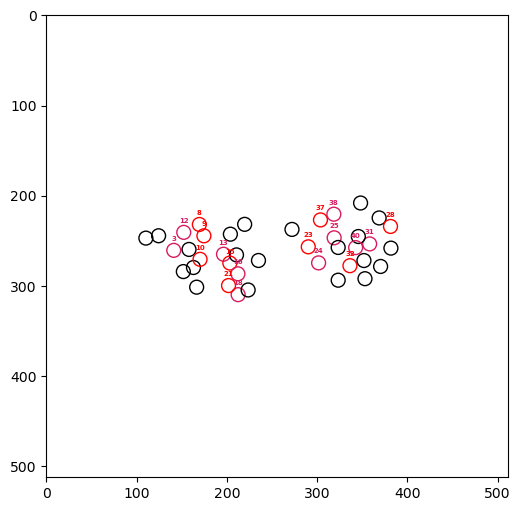

Saved: ./ROI_position_260128_fish1_Kstim.png


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== 1) ES結果（result）が既にある前提 =====
def classify_es(es):
    if es >= 1.7:
        return "strong"
    elif es >= 0.9:
        return "moderate"
    else:
        return "none"

result = result.copy()
result["K_level"] = result["ES_K"].apply(classify_es)

# resultのROIが "#12" 形式でも対応できるように int化
# 例: "#12" -> 12, "12" -> 12
result["ROI_int"] = (
    result["ROI"].astype(str).str.replace("#", "", regex=False).str.strip().astype(int)
)

# ===== 2) 位置情報のExcel =====
excel_file = "プルキンエ細胞_ROI_position.xlsx"
df = pd.read_excel(excel_file)
df.columns = df.columns.str.strip()

roi_col = "ROI"
x_col = "Center_x"
y_col = "Center_y"

df[roi_col] = df[roi_col].astype(int)

# ===== 3) 位置dfに K_level を付与（ROIで結合）=====
df = df.merge(
    result[["ROI_int", "ES_K", "K_level"]],
    left_on=roi_col,
    right_on="ROI_int",
    how="left"
)

# 結合できないROIは none 扱い
df["K_level"] = df["K_level"].fillna("none")

# ===== 画像サイズ =====
img_size = 512

# ===== スケール設定 =====
pixel_size_um = 0.65
radius_um = 5
radius_px = radius_um / pixel_size_um

# ===== 出力 =====
output_dir = "."
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, "ROI_position_260128_fish1_Kstim.png")

# ===== 描画 =====
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, img_size)
ax.set_ylim(0, img_size)
ax.set_aspect("equal")
ax.invert_yaxis()

for _, row in df.iterrows():
    roi_id = int(row[roi_col])
    x = row[x_col]
    y = row[y_col]
    level = row["K_level"]

    # 色分け
    if level == "strong":
        edge_color = "red"
        lw = 1.0
    elif level == "moderate":
        edge_color = "#d81b60"
        lw = 1.0
    else:
        edge_color = "black"
        lw = 1.0

    circle = plt.Circle(
        (x, y),
        radius_px,
        edgecolor=edge_color,
        facecolor="none",
        linewidth=lw
    )
    ax.add_patch(circle)

    # （任意）strong/moderateだけ番号を振る
    if level in ["strong", "moderate"]:
        ax.text(
            x, y - radius_px - 2,
            str(roi_id),
            color=edge_color,
            fontsize=5,
            ha="center",
            va="bottom",
            weight="bold"
        )

plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Saved:", out_path)

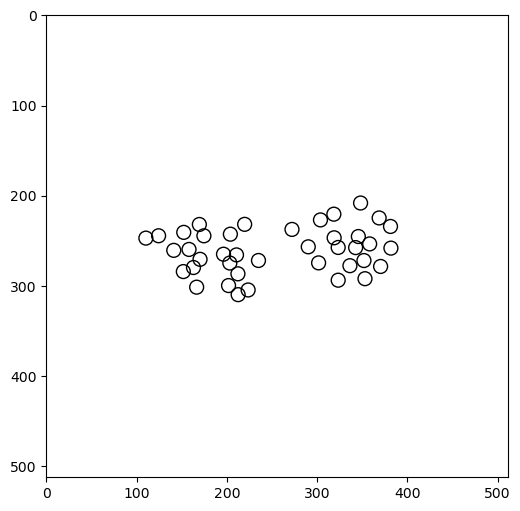

Saved: ./ROI_position_260128_fish1_Nstim.png


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== 1) ES_Nで分類 =====
def classify_es(es):
    if es >= 1.77:
        return "strong"
    elif es >= 1:
        return "moderate"
    else:
        return "none"

result_N = result.copy()
result_N["N_level"] = result_N["ES_N"].apply(classify_es)

# ROIをint化
result_N["ROI_int"] = (
    result_N["ROI"].astype(str)
    .str.replace("#", "", regex=False)
    .str.strip()
    .astype(int)
)

# ===== 2) 位置情報 =====
excel_file = "プルキンエ細胞_ROI_position.xlsx"
df = pd.read_excel(excel_file)
df.columns = df.columns.str.strip()

roi_col = "ROI"
x_col = "Center_x"
y_col = "Center_y"

df[roi_col] = df[roi_col].astype(int)

# ===== 3) merge =====
df = df.merge(
    result_N[["ROI_int", "ES_N", "N_level"]],
    left_on=roi_col,
    right_on="ROI_int",
    how="left"
)

df["N_level"] = df["N_level"].fillna("none")

# ===== 画像サイズ =====
img_size = 512
pixel_size_um = 0.65
radius_um = 5
radius_px = radius_um / pixel_size_um

# ===== 出力 =====
output_dir = "."
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, "ROI_position_260128_fish1_Nstim.png")

# ===== 描画 =====
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, img_size)
ax.set_ylim(0, img_size)
ax.set_aspect("equal")
ax.invert_yaxis()

for _, row in df.iterrows():
    roi_id = int(row[roi_col])
    x = row[x_col]
    y = row[y_col]
    level = row["N_level"]

    # 色分け（Nは青系にすると分かりやすい）
    if level == "strong":
        edge_color = "blue"
        lw = 1.0
    elif level == "moderate":
        edge_color = "#1e88e5"
        lw = 1.0
    else:
        edge_color = "black"
        lw = 1.0

    circle = plt.Circle(
        (x, y),
        radius_px,
        edgecolor=edge_color,
        facecolor="none",
        linewidth=lw
    )
    ax.add_patch(circle)

    if level in ["strong", "moderate"]:
        ax.text(
            x, y - radius_px - 2,
            str(roi_id),
            color=edge_color,
            fontsize=5,
            ha="center",
            va="bottom",
            weight="bold"
        )

plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Saved:", out_path)

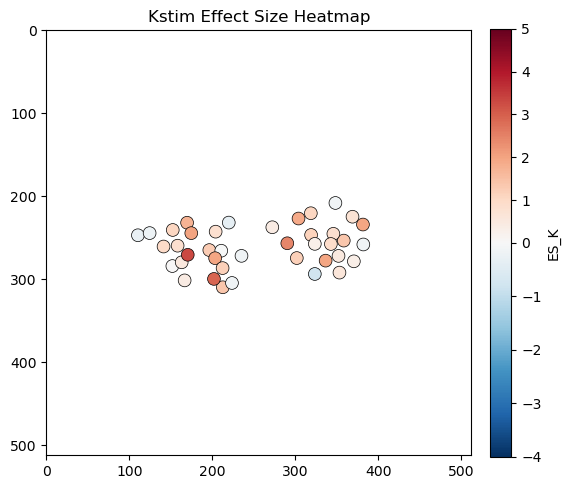

Saved: ./ROI_position_260128_fish1_Kstim_heatmap.png


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib


# ===== ES結果がある前提 =====
result_heat = result.copy()

# ROIをint化
result_heat["ROI_int"] = (
    result_heat["ROI"]
    .astype(str)
    .str.replace("#", "", regex=False)
    .str.strip()
    .astype(int)
)

# ===== 位置情報 =====
excel_file = "プルキンエ細胞_ROI_position.xlsx"
df = pd.read_excel(excel_file)
df.columns = df.columns.str.strip()

roi_col = "ROI"
x_col = "Center_x"
y_col = "Center_y"

df[roi_col] = df[roi_col].astype(int)

# ===== merge =====
df = df.merge(
    result_heat[["ROI_int", "ES_K"]],
    left_on=roi_col,
    right_on="ROI_int",
    how="left"
)

# ===== カラーマップ設定 =====
# 中心0の発散型にすると見やすい
vmin = -4
vmax = 5

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap = matplotlib.colormaps["RdBu_r"]   # 他に "RdBu_r", "seismic" なども良い

# ===== 描画設定 =====
img_size = 512
pixel_size_um = 0.65
radius_um = 5
radius_px = radius_um / pixel_size_um

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, img_size)
ax.set_ylim(0, img_size)
ax.set_aspect("equal")
ax.invert_yaxis()

for _, row in df.iterrows():
    roi_id = int(row[roi_col])
    x = row[x_col]
    y = row[y_col]
    es_val = row["ES_K"]

    if pd.isna(es_val):
        color = "black"
    else:
        color = cmap(norm(es_val))

    circle = plt.Circle(
        (x, y),
        radius_px,
        edgecolor="black",
        facecolor=color,
        linewidth=0.5
    )
    ax.add_patch(circle)

# ===== カラーバー =====
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("ES_K")

plt.title("Kstim Effect Size Heatmap")

# ===== 保存 =====
output_dir = "."
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, "ROI_position_260128_fish1_Kstim_heatmap.png")

plt.savefig(out_path, dpi=300, bbox_inches="tight")

# ===== 表示 =====
plt.show()

# ===== クローズ =====
plt.close()

print("Saved:", out_path)

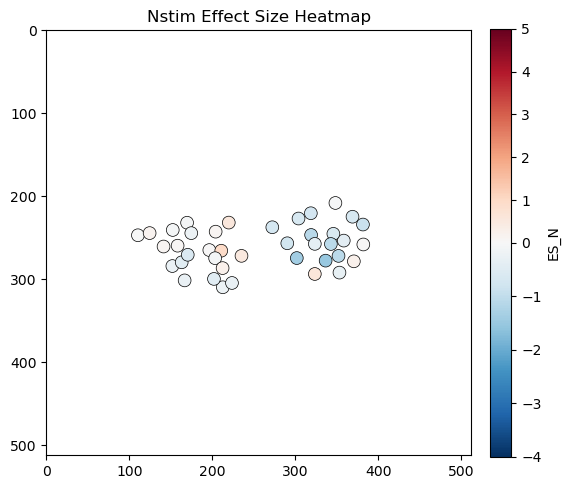

Saved: ./ROI_position_260128_fish1_Nstim_heatmap.png


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib


# ===== ES結果がある前提 =====
result_heat = result.copy()

# ROIをint化
result_heat["ROI_int"] = (
    result_heat["ROI"]
    .astype(str)
    .str.replace("#", "", regex=False)
    .str.strip()
    .astype(int)
)

# ===== 位置情報 =====
excel_file = "プルキンエ細胞_ROI_position.xlsx"
df = pd.read_excel(excel_file)
df.columns = df.columns.str.strip()

roi_col = "ROI"
x_col = "Center_x"
y_col = "Center_y"

df[roi_col] = df[roi_col].astype(int)

# ===== merge =====
df = df.merge(
    result_heat[["ROI_int", "ES_N"]],
    left_on=roi_col,
    right_on="ROI_int",
    how="left"
)

# ===== カラーマップ設定 =====
# 中心0の発散型にすると見やすい
vmin = -4
vmax = 5

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap = matplotlib.colormaps["RdBu_r"]   # 他に "RdBu_r", "seismic" なども良い

# ===== 描画設定 =====
img_size = 512
pixel_size_um = 0.65
radius_um = 5
radius_px = radius_um / pixel_size_um

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, img_size)
ax.set_ylim(0, img_size)
ax.set_aspect("equal")
ax.invert_yaxis()

for _, row in df.iterrows():
    roi_id = int(row[roi_col])
    x = row[x_col]
    y = row[y_col]
    es_val = row["ES_N"]

    if pd.isna(es_val):
        color = "black"
    else:
        color = cmap(norm(es_val))

    circle = plt.Circle(
        (x, y),
        radius_px,
        edgecolor="black",
        facecolor=color,
        linewidth=0.5
    )
    ax.add_patch(circle)

# ===== カラーバー =====
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("ES_N")

plt.title("Nstim Effect Size Heatmap")

# ===== 保存 =====
output_dir = "."
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, "ROI_position_260128_fish1_Nstim_heatmap.png")

plt.savefig(out_path, dpi=300, bbox_inches="tight")

# ===== 表示 =====
plt.show()

# ===== クローズ =====
plt.close()

print("Saved:", out_path)